In [44]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Flatten, concatenate, Lambda, BatchNormalization, Dropout
from tensorflow.keras.models import Model
import pandas as pd
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
import numpy as np
import tensorflow_hub as hub
import cv2
import csv
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.utils.vis_utils import plot_model
import tensorflow.keras.backend as K
from tensorflow.keras.applications.resnet50 import ResNet50
import cvlib as cv
import os

In [45]:
feature_vectors = pd.read_csv('team_vectors.csv')

In [46]:
feature_vector_dict = {}

In [47]:
for _, row in feature_vectors.iterrows():
    feature_vector_dict[row[1]] = np.fromstring(row[2][1:-1], sep=', ', dtype=float)

In [48]:
feature_vector_dict

{'DL': array([0.        , 0.        , 0.36152259, ..., 5.28034449, 1.31312311,
        5.60397768]),
 'JP': array([0.12309892, 0.        , 0.39085525, ..., 4.14608288, 0.19131023,
        1.39371192]),
 'KD': array([0.05809994, 0.        , 0.3929548 , ..., 7.58420753, 1.50368154,
        3.66423512]),
 'MV': array([0.        , 0.        , 0.53525496, ..., 2.36527395, 0.1929242 ,
        1.34479153]),
 'PZ': array([0.        , 0.        , 0.06230139, ..., 9.0072546 , 3.28696251,
        2.41526008])}

In [49]:
model = keras.models.load_model('models/v3_80pct_compare/')

In [50]:
import os
os.environ["TFHUB_CACHE_DIR"] = "C:/Users/karel"
hub_extractor = "https://tfhub.dev/google/bit/m-r50x1/1"

In [51]:
feature_extractor_layer = hub.KerasLayer(
    hub_extractor,
    input_shape=(224, 224, 3),
    trainable=False
)

In [52]:
input_layer_1 = Input(shape=(224,224,3), name="left_input")
input_layer_2 = Input(shape=(2048), name="right_input")

left = input_layer_1
right = input_layer_2

left = feature_extractor_layer(left)

out = model([left, right])

In [53]:
model = tf.keras.Model(inputs=[input_layer_1, input_layer_2], outputs = out)

In [54]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 keras_layer_1 (KerasLayer)     (None, 2048)         23500352    ['left_input[0][0]']             
                                                                                                  
 right_input (InputLayer)       [(None, 2048)]       0           []                               
                                                                                                  
 model_2 (Functional)           (None, 1)            533825      ['keras_layer_1[0][0]',      

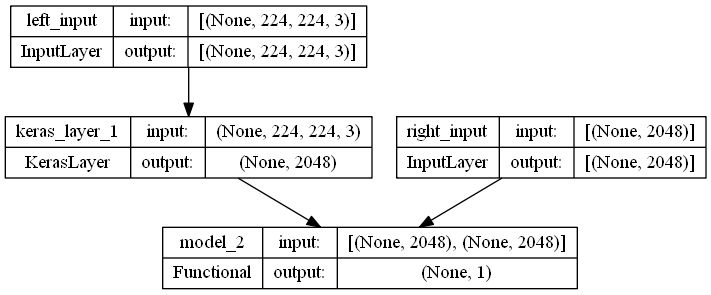

In [55]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [56]:
def get_face(image):
  img = cv2.imread(image)
  faces, confidences = cv.detect_face(img)
  path = image.replace('.jpg', '_cropped.jpg').replace('.jpeg', '_cropped.jpg')

  if os.path.exists(path):
    return path

  for face in faces:
        (startX,startY) = face[0],face[1]
        (endX,endY) = face[2],face[3]
        cropped_image = img[startY:endY, startX:endX]
        cv2.imwrite(path, cropped_image)
        return path

In [57]:
def preprocess_image(image):
    image_string = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image_string)

    resize = tf.keras.layers.Resizing (224, 224, interpolation='bilinear', crop_to_aspect_ratio=False)
    resized_image = resize(image)
    
    resized_image = tf.keras.applications.resnet50.preprocess_input(resized_image)
    resized_image = tf.image.convert_image_dtype(resized_image, tf.float32)

    return resized_image

In [58]:
import glob

In [72]:
for image_path in glob.glob(".\compare\*"):
    if 'cropped' in image_path:
        continue
        
    image = preprocess_image(get_face(image_path))
    
    image_row = {}
    
    for item in feature_vector_dict.items():
        res = model.predict(
            [
                np.expand_dims(image, axis=0),
                np.expand_dims(item[1], axis=0)
            ],
            verbose=False
        )
        
        image_row[item[0]] = res[0][0]
        
    print("---")
    
    print(image_path)
    print(image_row)
    
    print("---")

---
.\compare\1648024256025.jpg
{'DL': 0.0024633808, 'JP': 0.89225256, 'KD': 0.6001972, 'MV': 0.99181, 'PZ': 0.53379554}
---
---
.\compare\image0(3).jpeg
{'DL': 0.5652646, 'JP': 0.026446953, 'KD': 0.14837758, 'MV': 0.043505605, 'PZ': 0.4807547}
---
---
.\compare\IMG_20221124_181854.jpg
{'DL': 0.0027557479, 'JP': 0.85438246, 'KD': 0.63553756, 'MV': 0.78076947, 'PZ': 0.5448405}
---
---
.\compare\IMG_5294.JPG
{'DL': 0.8740119, 'JP': 0.0024315026, 'KD': 0.06376351, 'MV': 0.01646562, 'PZ': 0.036573093}
---
---
.\compare\IMG_Douda_1.jpg
{'DL': 0.041504893, 'JP': 0.8761351, 'KD': 0.99181104, 'MV': 0.6508584, 'PZ': 0.6517751}
---
---
.\compare\IMG_Douda_2.jpeg
{'DL': 0.081066005, 'JP': 0.1360572, 'KD': 0.60562444, 'MV': 0.116041414, 'PZ': 0.32391867}
---
---
.\compare\IMG_Prokop.jpg
{'DL': 0.00094830093, 'JP': 0.9918114, 'KD': 0.6887433, 'MV': 0.7376794, 'PZ': 0.3067885}
---
---
.\compare\IMG_Zeman.jpg
{'DL': 0.048461534, 'JP': 0.5881602, 'KD': 0.6636165, 'MV': 0.70472074, 'PZ': 0.99181527}
--